In [1]:
import pandas as pd
pd.set_option('display.max_columns', 50)
import numpy as np
import matplotlib.pyplot as plt
import pystan
%matplotlib inline
import scipy.stats as stats

In [2]:
torndata = pd.read_csv('AM207-Twister/1950-2014_torn.warnings.csv', header=None)
torndata.columns = ['om', 'yr', 'mo', 'dy', 'date', 'time', 'tz', 'st', 'stf', 'stn', 'f', 'inj', 'fat', 'loss', 'closs', 'slat', 'slon', 'elat', 'elon', 'len', 'wid', 'ns', 'sn', 'sg', 'f1', 'f2', 'f3', 'f4', 'touchdown', 'has_warning', 'has_watch', 'warning_time']
torndata.head()

,om,yr,mo,dy,date,time,tz,st,stf,stn,f,inj,fat,loss,closs,slat,slon,elat,elon,len,wid,ns,sn,sg,f1,f2,f3,f4,touchdown,has_warning,has_watch,warning_time
0,1,1950,1,3,1950-01-03,11:00:00,3,MO,29,1,3,3,0,6,0,38.77,-90.22,38.83,-90.03,9.5,150,2,0,1,0,0,0,0,1950-01-03 17:00:00,False,False,0
1,1,1950,1,3,1950-01-03,11:00:00,3,MO,29,1,3,3,0,6,0,38.77,-90.22,38.82,-90.12,6.2,150,2,1,2,189,0,0,0,1950-01-03 17:00:00,False,False,0
2,1,1950,1,3,1950-01-03,11:10:00,3,IL,17,1,3,0,0,5,0,38.82,-90.12,38.83,-90.03,3.3,100,2,1,2,119,0,0,0,1950-01-03 17:10:00,False,False,0
3,2,1950,1,3,1950-01-03,11:55:00,3,IL,17,2,3,3,0,5,0,39.10,-89.30,39.12,-89.23,3.6,130,1,1,1,135,0,0,0,1950-01-03 17:55:00,False,False,0
4,3,1950,1,3,1950-01-03,16:00:00,3,OH,39,1,1,1,0,4,0,40.88,-84.58,0.00,0.00,0.1,10,1,1,1,161,0,0,0,1950-01-03 22:00:00,False,False,0


In [3]:
states_used = ['MT','WY','CO','ND','SD','NE','KS','OK','MN','IA','MO','AR']
torndatasel = torndata[(torndata['sn'] == 1) & (torndata['yr'] >= 1985) & (torndata['f'] == 3) &
                       torndata['st'].isin(states_used)]
torndatasel.head()

,om,yr,mo,dy,date,time,tz,st,stf,stn,f,inj,fat,loss,closs,slat,slon,elat,elon,len,wid,ns,sn,sg,f1,f2,f3,f4,touchdown,has_warning,has_watch,warning_time
25212,97,1985,4,20,1985-04-20,20:19:00,3,MN,27,1,3,2,0,6,0,43.90,-96.10,44.02,-96.00,8,250,1,1,1,117,101,0,0,1985-04-21 02:19:00,False,False,0
25254,136,1985,4,23,1985-04-23,15:14:00,3,AR,5,4,3,0,0,1,0,33.02,-93.82,33.05,-93.63,11,200,2,1,2,73,0,0,0,1985-04-23 21:14:00,False,False,0
25320,203,1985,5,10,1985-05-10,15:10:00,3,KS,20,5,3,0,0,5,0,38.93,-99.63,39.10,-99.63,10,300,1,1,1,195,0,0,0,1985-05-10 21:10:00,False,False,0
25322,205,1985,5,10,1985-05-10,15:50:00,3,KS,20,6,3,0,0,6,0,39.18,-99.52,39.47,-99.10,30,300,1,1,1,163,0,0,0,1985-05-10 21:50:00,False,False,0
25324,207,1985,5,10,1985-05-10,17:02:00,3,NE,31,21,3,2,0,6,0,40.77,-99.00,40.90,-98.73,17,500,1,1,1,19,0,0,0,1985-05-10 23:02:00,False,False,0


In [4]:
years = torndatasel['yr'].unique()
yearsdict = {}
for i in xrange(len(years)):
    yearsdict[years[i]] = i

In [5]:
landdata = pd.read_csv('DEC_10_DP_G001_with_ann.csv', skiprows=1, header=0, index_col='Id2')
landdata = landdata['AREA CHARACTERISTICS - Area (Land)']
landdata.head()

Id2
1001    1539582278
1003    4117521611
1005    2291818968
1007    1612480789
1009    1669961855
Name: AREA CHARACTERISTICS - Area (Land), dtype: int64

In [6]:
counties = landdata.index.values
countiesdict = {}
for i in xrange(len(counties)):
    countiesdict[counties[i]] = i

In [7]:
popdata = pd.read_csv('PEP_2014_PEPANNRES_with_ann.csv', skiprows=1, header=0, index_col='Id2')
popdata = popdata['April 1, 2010 - Census']
popdata.head()

Id2
1001     54571
1003    182265
1005     27457
1007     22915
1009     57322
Name: April 1, 2010 - Census, dtype: int64

In [8]:
torndatasel['pop_dens'] = 0 # need better way to make column?

/home/stephen/miniconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [9]:
for i in torndatasel.index:
    population = 0.
    area = 0.
    density = 0.
    row = torndatasel.loc[i]
    for column in ['f1', 'f2', 'f3', 'f4']:
        county = row[column]
        if county != 0:
            county += row['stf'] * 1000
            population += popdata[county]
            area += landdata[county]
    torndatasel.loc[i, 'pop_dens'] = population / float(area)#dens
torndatasel.head()

/home/stephen/miniconda/lib/python2.7/site-packages/pandas/core/indexing.py:411: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,om,yr,mo,dy,date,time,tz,st,stf,stn,f,inj,fat,loss,closs,slat,slon,elat,elon,len,wid,ns,sn,sg,f1,f2,f3,f4,touchdown,has_warning,has_watch,warning_time,pop_dens
25212,97,1985,4,20,1985-04-20,20:19:00,3,MN,27,1,3,2,0,6,0,43.90,-96.10,44.02,-96.00,8,250,1,1,1,117,101,0,0,1985-04-21 02:19:00,False,False,0,0.000006
25254,136,1985,4,23,1985-04-23,15:14:00,3,AR,5,4,3,0,0,1,0,33.02,-93.82,33.05,-93.63,11,200,2,1,2,73,0,0,0,1985-04-23 21:14:00,False,False,0,0.000006
25320,203,1985,5,10,1985-05-10,15:10:00,3,KS,20,5,3,0,0,5,0,38.93,-99.63,39.10,-99.63,10,300,1,1,1,195,0,0,0,1985-05-10 21:10:00,False,False,0,0.000001
25322,205,1985,5,10,1985-05-10,15:50:00,3,KS,20,6,3,0,0,6,0,39.18,-99.52,39.47,-99.10,30,300,1,1,1,163,0,0,0,1985-05-10 21:50:00,False,False,0,0.000002
25324,207,1985,5,10,1985-05-10,17:02:00,3,NE,31,21,3,2,0,6,0,40.77,-99.00,40.90,-98.73,17,500,1,1,1,19,0,0,0,1985-05-10 23:02:00,False,False,0,0.000018


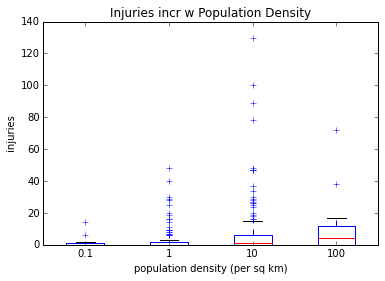

In [10]:
plt.boxplot([(torndatasel[np.log10(torndatasel['pop_dens'].values) // 1 == y])['inj'].values for y in [-7, -6, -5, -4]])
plt.xlabel('population density (per sq km)')
plt.ylabel('injuries')
plt.xticks([1,2,3,4],[0.1,1,10,100])
plt.title('Injuries incr w Population Density')
plt.show()

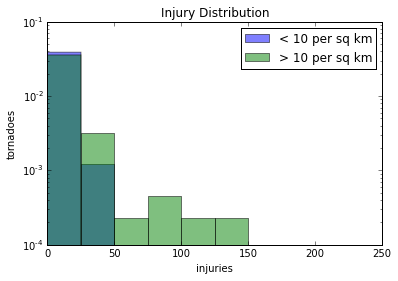

In [11]:
plt.hist(torndatasel[torndatasel['pop_dens'] < 1e-5]['inj'].values, log=True, label='< 10 per sq km', alpha=0.5, range=(0,250), normed=True)
plt.hist(torndatasel[torndatasel['pop_dens'] > 1e-5]['inj'].values, log=True, label='> 10 per sq km', alpha=0.5, range=(0,250), normed=True)
plt.xlabel('injuries')
plt.ylabel('tornadoes')
plt.title('Injury Distribution')
plt.legend()
plt.show()

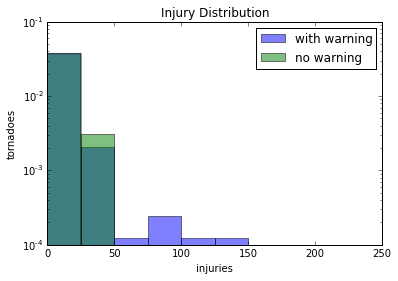

In [12]:
plt.hist(torndatasel[torndatasel['has_warning'] == True]['inj'].values, log=True, label='with warning', normed=True, range=(0,250), alpha=0.5)
plt.hist(torndatasel[torndatasel['has_warning'] == False]['inj'].values, log=True, label='no warning', normed=True, range=(0,250), alpha=0.5)
plt.xlabel('injuries')
plt.ylabel('tornadoes')
plt.title('Injury Distribution')
plt.legend()
plt.show()

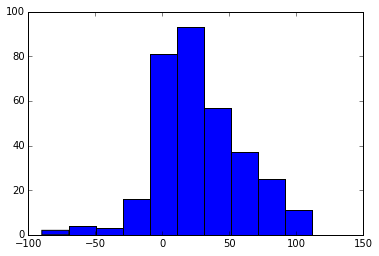

In [13]:
plt.hist(torndatasel[torndatasel['has_warning'] == True]['warning_time'].values)
plt.show()

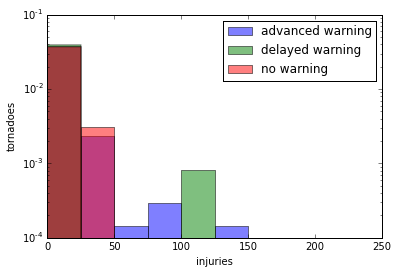

In [14]:
plt.hist(torndatasel[np.logical_and(torndatasel['has_warning'] == True, torndatasel['warning_time'] > 0)]['inj'].values,
          log=True, normed=True, alpha=0.5, range=(0,250), label='advanced warning')
plt.xlabel('injuries')
plt.ylabel('tornadoes')
#plt.title('Injury Distribution, advanced warning')
#plt.show()
plt.hist(torndatasel[np.logical_and(torndatasel['has_warning'] == True, torndatasel['warning_time'] < 0)]['inj'].values,
          log=True, normed=True, alpha=0.5, range=(0,250), label='delayed warning')
plt.xlabel('injuries')
plt.ylabel('tornadoes')
#plt.title('Injury Distribution, delayed warning')
#plt.show()
plt.hist(torndatasel[torndatasel['has_warning'] == False]['inj'].values, log=True, normed=True, alpha=0.5, range=(0,250), label='no warning')
#plt.xlabel('injuries')
#plt.ylabel('tornadoes')
#plt.title('Injury Distribution, no warning')
plt.legend()
plt.show()

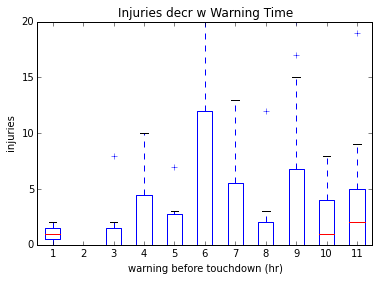

In [15]:
torndatawarn = torndatasel[torndatasel['has_warning'] == True]
plt.boxplot([(torndatawarn[torndatawarn['warning_time'].values // 5 == y])['inj'].values for y in [-5,-4,-3,-2,-1,0,1,2,3,4,5]])
plt.xlabel('warning before touchdown (hr)')
plt.ylabel('injuries')
#plt.xticks([1,2,3,4,5],[-1,-0.5,0,0.5,1])
plt.title('Injuries decr w Warning Time')
plt.ylim((0,20))
plt.show()

In [16]:
earlywarning = np.logical_and(torndatasel['has_warning'], torndatasel['warning_time'] > 0)

In [17]:
states = torndatasel['st'].unique()
tornsts = np.empty((torndatasel.index.size, states.size), dtype=np.bool)

for i in xrange(states.size):
    tornsts[:, i] = (torndatasel['st'] == states[i])

In [18]:
tornyrs = np.empty((torndatasel.index.size,10), dtype=np.bool)
for i in xrange(10):
    tornyrs[:,i] = np.logical_and(torndatasel['yr'] >= 1985 + i*3, torndatasel['yr'] < 1988 + i*3)

In [19]:
tornado_model = """
data {
    int N_torn; // Number of tornados
    int N_yr; // number of time periods
    int N_st; // number of states
    vector[N_torn] logpopdens; // effective population density
    int y[N_torn]; // number of injuries
    vector[N_torn] earlywarning;
    matrix[N_torn, N_yr] tornyrs;
    matrix[N_torn, N_st] tornsts;
}
parameters {
    real const_factor;
    real popdens_power;
    vector[N_torn] noise_factor;
    real<lower=0> noise_hp_sig;
    
    real warning_factor;
    
    vector[N_yr] year_factor;
    real<lower=0> yr_hp_sig;
    
    vector[N_st] state_factor;
    
    real<lower=0> phi;
}
transformed parameters {
    vector[N_torn] lambda;
    lambda <- exp(const_factor + popdens_power * logpopdens + tornsts * state_factor + tornyrs * year_factor +
        warning_factor * earlywarning + noise_factor);
}
model  {
    phi ~ cauchy(0, 1);
    y ~ neg_binomial_2(lambda, phi);
    noise_factor ~ normal(0, noise_hp_sig);
    noise_hp_sig ~ cauchy(0, 1);
    year_factor ~ normal(0, yr_hp_sig);
    yr_hp_sig ~ cauchy(0, 1);
    state_factor ~ cauchy(0, 1);
}
"""

In [20]:
tornado_dat = {'N_torn':len(torndatasel.index),
               'N_yr': 10,
               'N_st':states.size,
               'tornsts':tornsts.astype(int),
               'tornyrs':tornyrs.astype(int),
               'earlywarning':earlywarning.astype(int),
               'logpopdens':np.log(torndatasel['pop_dens'].values),
               'y':torndatasel['inj'].values}

In [21]:
niter = 1000
fit = pystan.stan(model_code=tornado_model, data=tornado_dat, iter=2*niter, chains=1)

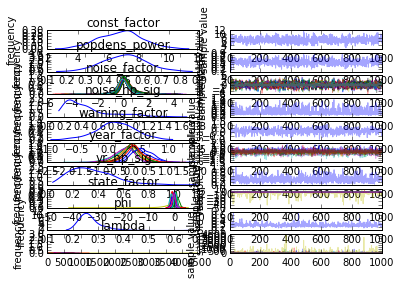

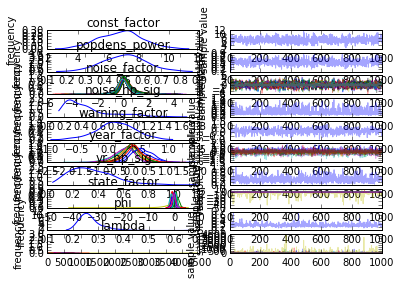

In [22]:
fit.plot()

In [23]:
extract = fit.extract(permuted=True)

In [37]:
import pickle
f = open('injurymodelling.pkl', 'w')
pickle.dump(states.astype(list), f)
pickle.dump(extract, f)
f.close()

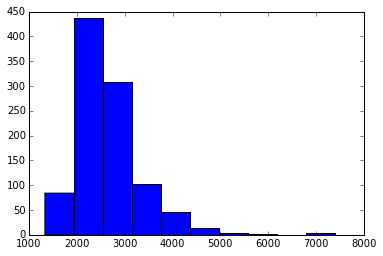

In [24]:
plt.hist(np.sum(extract['lambda'], axis=1))
plt.show()

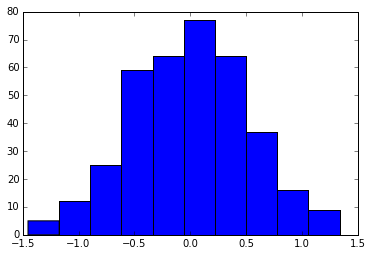

In [25]:
i = np.random.randint(niter)
plt.hist(extract['noise_factor'][i])
plt.show()

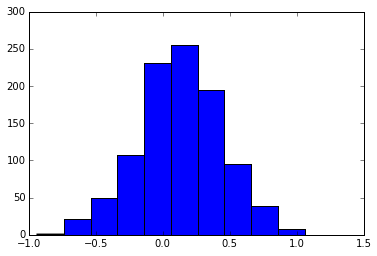

In [26]:
plt.hist(extract['warning_factor'])
plt.show()

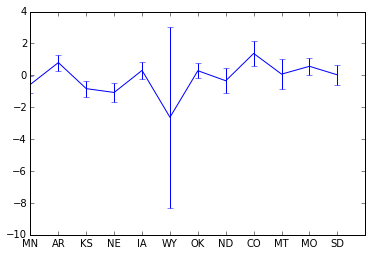

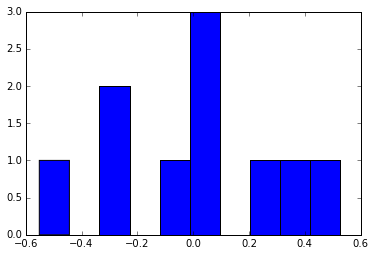

In [27]:
plt.errorbar(xrange(states.size), np.mean(extract['state_factor'], axis=0), np.std(extract['state_factor'], axis=0))
plt.xticks(xrange(states.size), states)
plt.show()
i = np.random.randint(niter)
plt.hist(extract['year_factor'][i])
#plt.xticks(xrange(states.size), states)
plt.show()

In [28]:
i = np.random.randint(niter)
for x in states:
    print x
for x in np.mean(extract['state_factor'], axis=0):
    print x

MN
AR
KS
NE
IA
WY
OK
ND
CO
MT
MO
SD
-0.561526849073
0.801689359286
-0.832325199882
-1.07176469818
0.312940227447
-2.62960709445
0.292992325603
-0.337744119206
1.37656827079
0.077929016404
0.569127556933
0.0326440822421


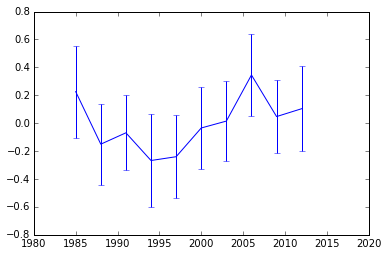

In [29]:
plt.errorbar(np.arange(1985, 2015, 3), np.mean(extract['year_factor'], axis=0), np.std(extract['year_factor'], axis=0))
plt.xlim((1980, 2020))
plt.show()

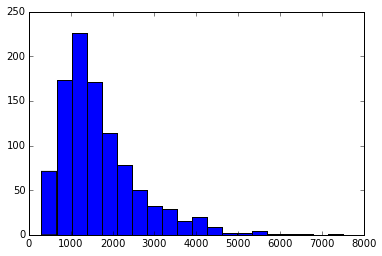

In [30]:
injuryhist = []
for i in xrange(niter):
    const_factor = extract['const_factor'][i]
    noise_factor = np.random.normal(scale=extract['noise_hp_sig'][i], size=torndatasel.index.size)
    predinjuries = torndatasel['pop_dens'].values**extract['popdens_power'][i] * np.exp(const_factor)
    lambdas = torndatasel['pop_dens'].values**extract['popdens_power'][i] * np.exp(const_factor + noise_factor)
    phi = extract['phi'][i]
    injuries = np.sum(stats.nbinom.rvs(phi, phi/(lambdas+phi)))
    injuryhist.append(injuries)
plt.hist(injuryhist, bins=20)
plt.show()

Predicted injuries: 1172
Actual injuries: 1951


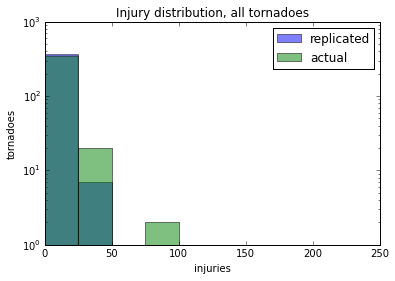

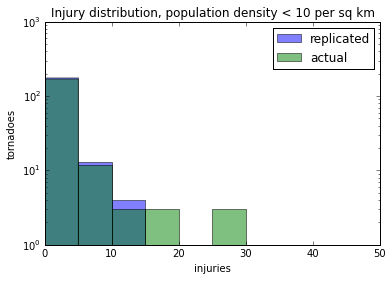

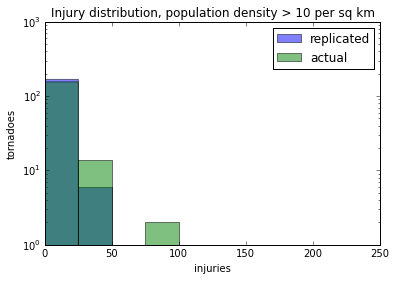

In [31]:
i = np.random.randint(niter)
const_factor = extract['const_factor'][i]
#noise_factor = extract['noise_factor'][i]
noise_factor = np.random.normal(scale=extract['noise_hp_sig'][i], size=torndatasel.index.size)
predinjuries = torndatasel['pop_dens'].values**extract['popdens_power'][i] * np.exp(const_factor)
lambdas = torndatasel['pop_dens'].values**extract['popdens_power'][i] * np.exp(const_factor + noise_factor)
phi = extract['phi'][i]
injuries = stats.nbinom.rvs(phi, phi/(lambdas+phi))
print "Predicted injuries:", np.sum(injuries)
print "Actual injuries:", np.sum(torndatasel['inj'].values)
plt.hist(injuries, log=True, alpha=0.5, range=(0,250), label='replicated')
plt.hist(torndatasel['inj'].values, log=True, alpha=0.5, range=(0,250), label='actual')
plt.xlabel('injuries')
plt.ylabel('tornadoes')
plt.legend()
plt.title('Injury distribution, all tornadoes')
plt.show()
plt.hist(injuries[torndatasel['pop_dens'].values < 1e-5], log=True, alpha=0.5, range=(0,50), label='replicated')
plt.hist(torndatasel['inj'].values[torndatasel['pop_dens'].values < 1e-5], log=True, alpha=0.5, range=(0,50), label='actual')
plt.xlabel('injuries')
plt.ylabel('tornadoes')
plt.legend()
plt.title('Injury distribution, population density < 10 per sq km')
plt.show()
plt.hist(injuries[torndatasel['pop_dens'].values > 1e-5], log=True, alpha=0.5, range=(0,250), label='replicated')
plt.hist(torndatasel['inj'].values[torndatasel['pop_dens'].values > 1e-5], log=True, alpha=0.5, range=(0,250), label='actual')
plt.xlabel('injuries')
plt.ylabel('tornadoes')
plt.legend()
plt.title('Injury distribution, population density > 10 per sq km')
plt.show()